In [1]:
import cupy as cp
import numpy as np

if cp.cuda.is_available():
	print("GPU is available")
	print("GPU: ", cp.cuda.runtime.getDeviceProperties(0)['name'])

GPU is available
GPU:  b'NVIDIA GeForce RTX 4070 SUPER'


In [2]:
import os
import tempfile
from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.dpi"] = 300

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

C:\Users\cordo\AppData\Roaming\Python\Python310\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [48]:
MAKE_ANIMATIONS = True


def check_folder(folder_name):
	if not os.path.exists(folder_name):
		os.makedirs(folder_name)
		print(f"Folder '{folder_name}' created.")
	else:
		print(f"Folder '{folder_name}' already exists.")


def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)

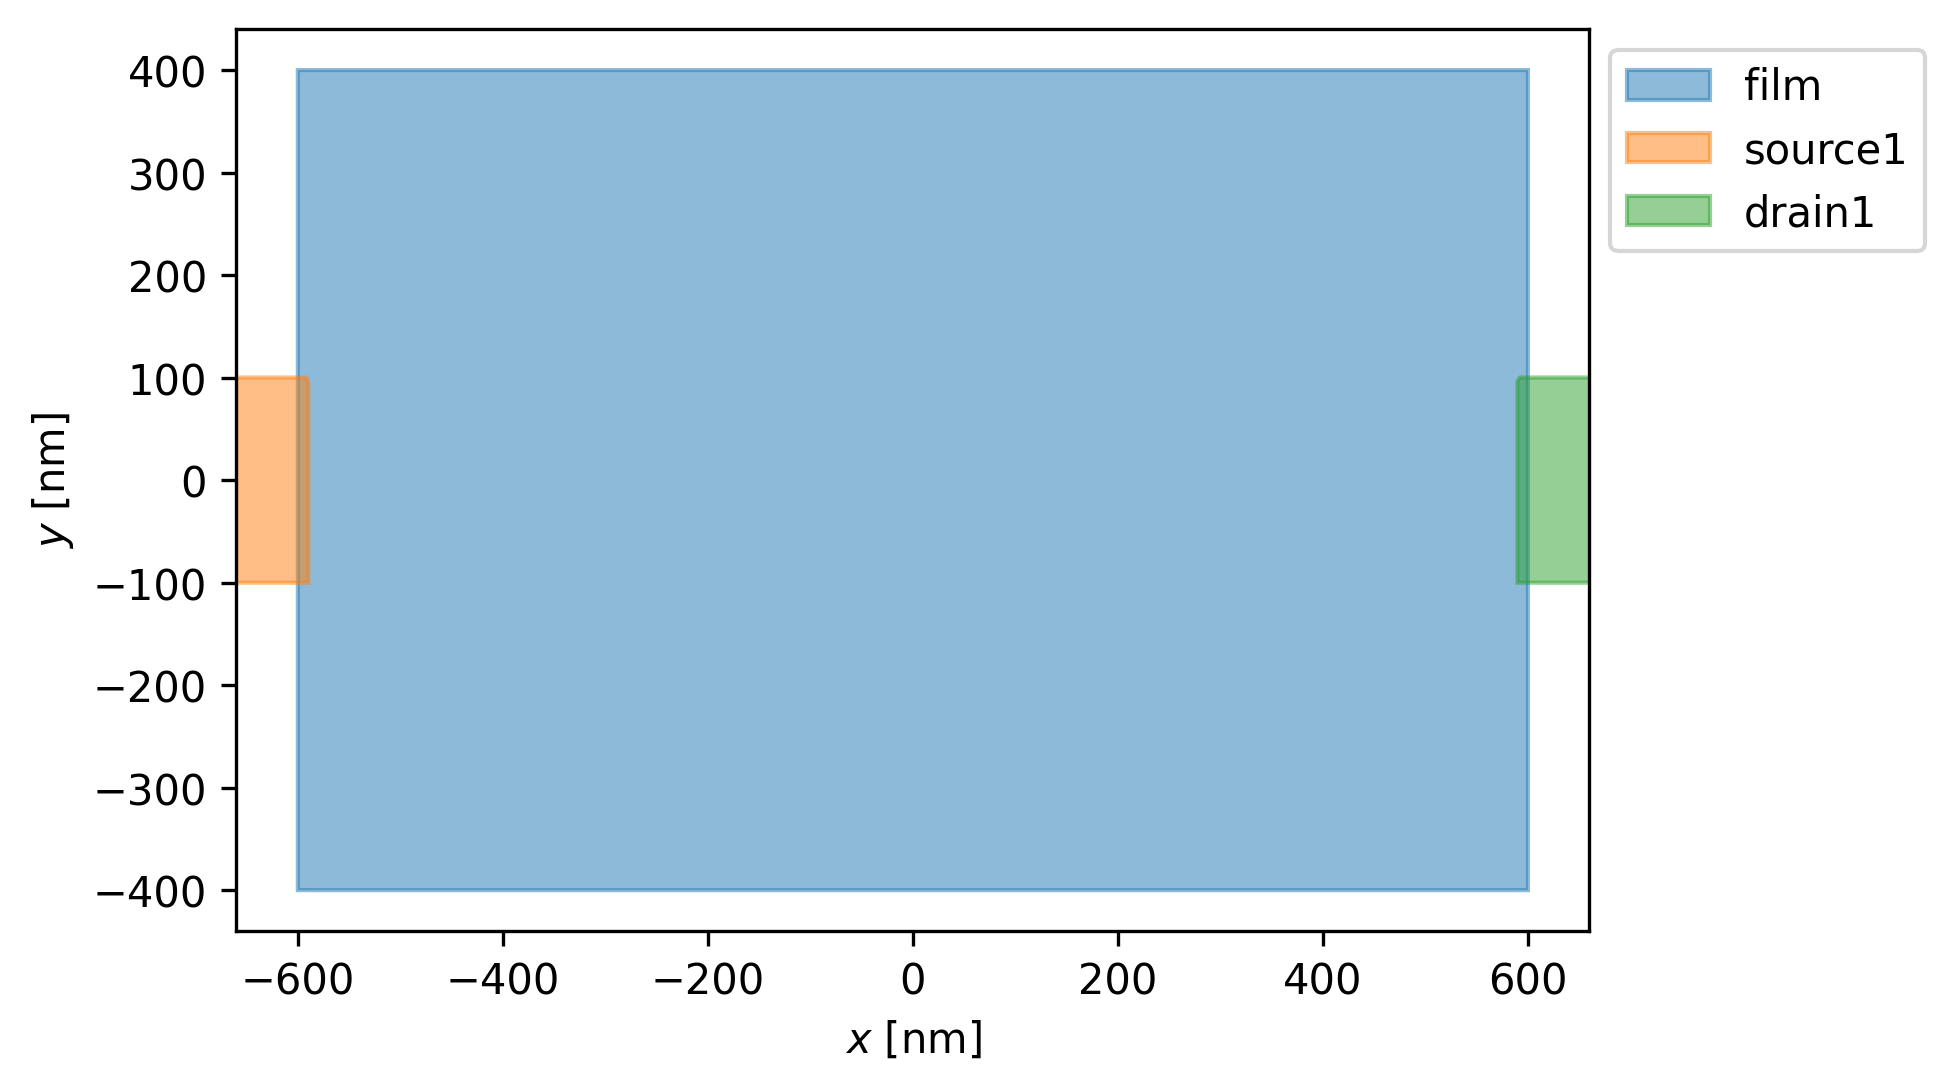

In [41]:
length_units = "nm"
# Material parameters
xi = 100
london_lambda = 100
d = 100
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

width = 12*xi
height = 8*xi

film = (
	tdgl.Polygon('film', points=box(width, height)).resample(401).buffer(0.1)
)

source1 = tdgl.Polygon('source1', points=box(xi,2*xi)).translate(-width/2-0.4*xi, 0 ).buffer(0.1).resample(401)
drain1 = source1.scale(xfact=-1).set_name("drain1")


device=tdgl.Device("2currents",
				   layer=layer 
				   ,film=film
				   ,terminals= [source1,drain1]
				   ,length_units=length_units
				   )

fig,ax=device.draw()

In [ ]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)
device.mesh_stats()

Constructing Voronoi polygons: 100%|██████████| 5534/5534 [00:02<00:00, 2039.29it/s]


num_sites,5534
num_elements,10666
min_edge_length,6.218e+00
max_edge_length,2.454e+01
mean_edge_length,1.436e+01
min_area,2.280e+01
max_area,3.965e+02
mean_area,1.735e+02
coherence_length,100
length_units,nm


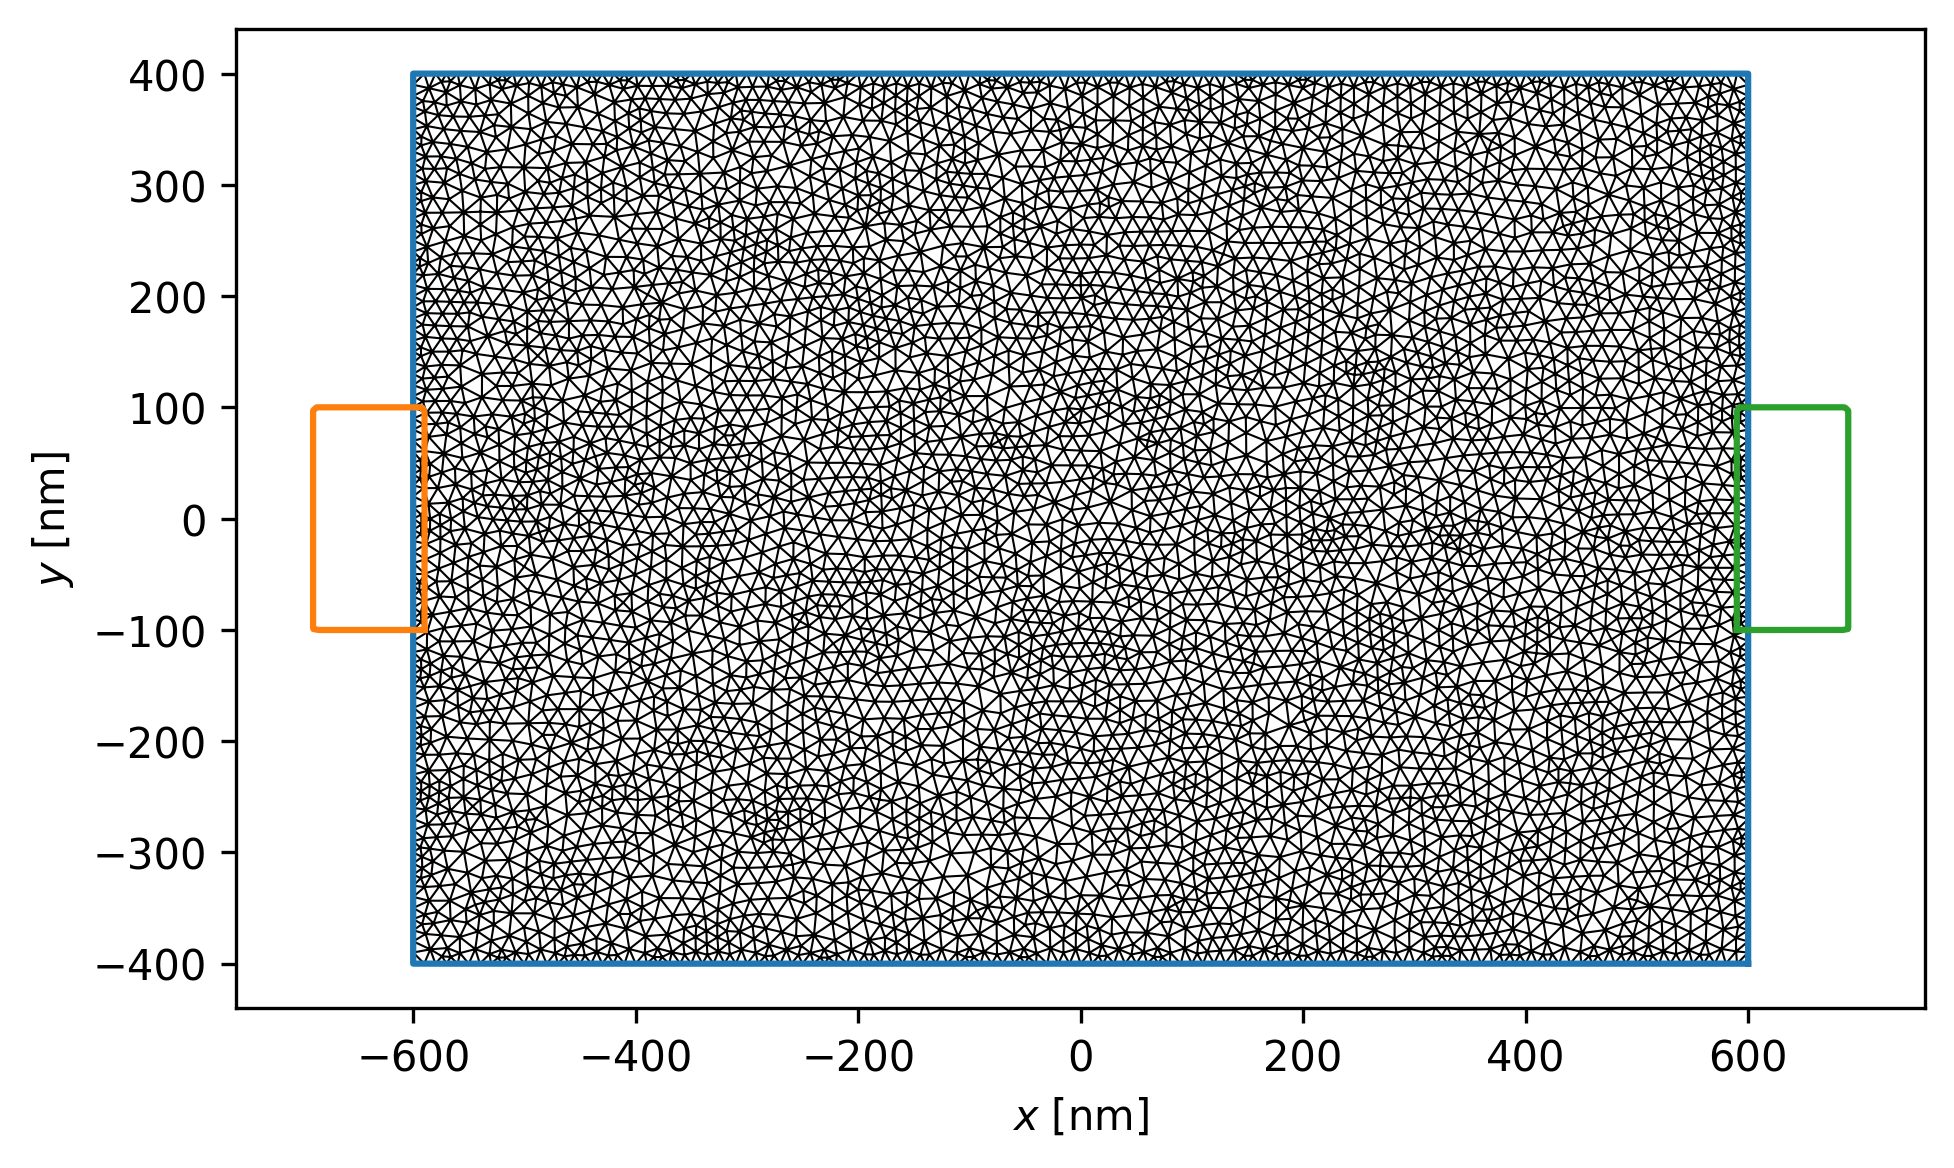

In [45]:
fig, ax = device.plot(mesh=True, legend=False)

In [52]:
folder_name = "output"
check_folder(folder_name)




options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,		# amount of time to skip before saving data - thermalization time
    solve_time=150, 	# total time
    output_file=os.path.join(os.getcwd(), folder_name),
    field_units = "mT", # magnetic field units
    current_units="uA",	# current units for the terminals
    save_every=100,
)
H_field=tdgl.sources.constant.ConstantField(0.4,
											field_units=options.field_units,
											length_units=device.length_units
											)


Folder 'output' already exists.


In [ ]:
zero_current_solution = tdgl.solve(
	device,
	options=options,
	applied_vector_potential=H_field
)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))